In [1]:
# Import libraries + data
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.utils import resample
from bees_lifetimetracking_2018data import definitions2024 as bn
allEventsFewer = pd.read_csv('allEventsFewer.csv')
ages = pd.read_csv('ages.csv')

# Tidying
allEventsFewer = allEventsFewer.drop(columns=['Unnamed: 0']).sort_values(by=['uid', 'framenum'])
ages = ages.drop(columns=['Unnamed: 0'])

# Type matching for merge
ages['Bee unique ID'] = ages['Bee unique ID'].apply(
    lambda x: str(int(float(x))) if isinstance(x, (int, float)) else str(x)
)
allEventsFewer['uid'] = allEventsFewer['uid'].astype(str)
allEventsFewer['uid'] = allEventsFewer['uid'].astype(int)
ages['Bee unique ID'] = ages['Bee unique ID'].astype(int)

# Adding recent_df_visits
allEventsFewer = bn.numOfDanceFloorVisits(allEventsFewer, allEventsFewer, 1800)
allEventsFewer

# Whittle down dfs
allEventsMerge = allEventsFewer[['daynum', 'uid', 'framenum', 'datetime', 'running_total_df_visits', 'recent_df_visits', 'status']]
agesMerge = ages.drop_duplicates()

# Merge
result = allEventsFewer.merge(agesMerge, left_on='uid', right_on='Bee unique ID', how='left')
result = result.drop(columns=['Bee unique ID', 'running_total_df_visits'])

# Splitting datetime
result['datetime'] = pd.to_datetime(result['datetime'])
result['year'] = result['datetime'].dt.year
result['month'] = result['datetime'].dt.month
result['day'] = result['datetime'].dt.day
result['hour'] = result['datetime'].dt.hour
result['minute'] = result['datetime'].dt.minute
result['second'] = result['datetime'].dt.second

# DF ready for analysis!
result = result.sort_values(by=['uid', 'datetime'])
result = result[['uid', 'Age', 'year', 'month', 'day', 'hour', 'minute', 'second', 'recent_df_visits', 'status']]
result

,daynum,uid,Age,year,month,day,hour,minute,second,recent_df_visits,status
0,20,846,30.0,2018,8,5,2,48,34,0.0,no change
1,20,846,30.0,2018,8,5,2,48,36,0.0,no change
2,20,846,30.0,2018,8,5,2,48,37,0.0,no change
3,20,846,30.0,2018,8,5,2,48,43,0.0,no change
4,20,846,30.0,2018,8,5,2,48,44,0.0,no change
...,...,...,...,...,...,...,...,...,...,...,...
3765337,20,3103,0.0,2018,8,5,22,54,9,0.0,no change
3765338,20,3103,0.0,2018,8,5,22,54,10,0.0,no change
3765339,20,3103,0.0,2018,8,5,22,54,12,0.0,no change
3765340,20,3103,0.0,2018,8,5,22,54,14,0.0,no change


## Data Prep

In [2]:
result.status.value_counts()

status
no change    3764741
leave            601
Name: count, dtype: int64

In [3]:
# Balancing data
df = pd.concat([
    resample(result[result['status'] == 'no change'], n_samples=601, random_state=42),
    result[result['status'] == 'leave']
]).sample(frac=1, random_state=42).reset_index(drop=True)
df.status.value_counts()

status
leave        601
no change    601
Name: count, dtype: int64

In [4]:
# quick switch from no change and leave to 0 and 1
df['status'] = df['status'].map({'no change': 0, 'leave': 1})

# Split Train and Test Data
from sklearn.model_selection import train_test_split

y = df['status']
X = df[['Age','year', 'month', 'day', 'hour', 'minute', 'second', 'recent_df_visits']]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=25)

In [5]:
# more libraries
import seaborn as sns
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
import matplotlib.pyplot as plt
%matplotlib inline


In [6]:
# snatched straight from Padma <3
def model_performance(model,x_train,x_test, y_train,y_test):
    print(f"{model} Performance:\n")
    
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    sns.set(rc = {'figure.figsize':(6,4)})
    sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
    yticklabels = ['No Forage', 'Forage'], xticklabels = ['Predicted no forage', 'Predicted forage'])
    plt.show()
   
    
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)

    cross_val_score_insample = cross_val_score(model,x_train,y_train,cv=5,scoring='accuracy').mean()
    cross_val_score_outsample = cross_val_score(model,x_test,y_test,cv=5,scoring='accuracy').mean()
    
    print('Precision Score:',precision)
    print("Recall Score:",recall)
    print("Accuracy Score:",accuracy)
    print('F1 Score:',f1)
    print("Cross Val Score Insample",cross_val_score_insample)
    print("Cross Val Score Outsample",cross_val_score_outsample)
    
    return model,precision,recall,accuracy,cross_val_score_insample,cross_val_score_outsample

## Naive Bayes

GaussianNB() Performance:



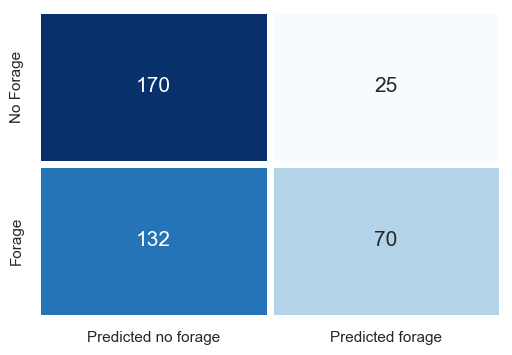

Precision Score: 0.7368421052631579
Recall Score: 0.3465346534653465
Accuracy Score: 0.6045340050377834
F1 Score: 0.4713804713804714
Cross Val Score Insample 0.6496894409937888
Cross Val Score Outsample 0.6147784810126582


In [7]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

performance_nb = model_performance(gnb, X_train, X_test, y_train, y_test)

## KNN

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn_temp_model = KNeighborsClassifier()
param_grid={'weights' : ['uniform','distance'],'n_neighbors' : (np.arange(9)+2)}
knn_grid = GridSearchCV(knn_temp_model,param_grid,cv=5,scoring='accuracy',verbose=1)
grid_results = knn_grid.fit(X_train,y_train)
best_k = knn_grid.best_params_['n_neighbors']
print("\t Ideal K-Val: {}".format(best_k))
print("\t Accuracy of Tuned Training Data: {:.2f}%".format(grid_results.best_score_ * 100))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
	 Ideal K-Val: 6
	 Accuracy of Tuned Training Data: 63.73%


KNeighborsClassifier(n_neighbors=6) Performance:



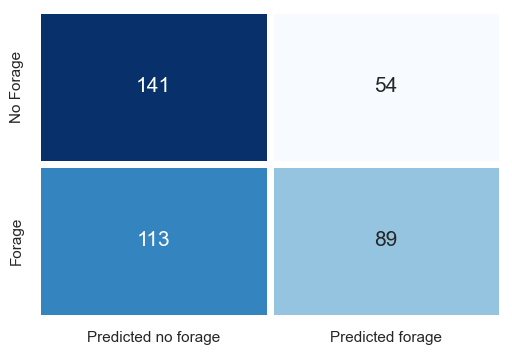

Precision Score: 0.6223776223776224
Recall Score: 0.4405940594059406
Accuracy Score: 0.5793450881612091
F1 Score: 0.5159420289855072
Cross Val Score Insample 0.6186335403726708
Cross Val Score Outsample 0.5796202531645569


In [9]:
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train, y_train)
performance_knn = model_performance(knn_model,X_train, X_test, y_train, y_test)

## Logistic Regression

Number of mislabeled points out of a total 397 points : 135
LogisticRegression() Performance:



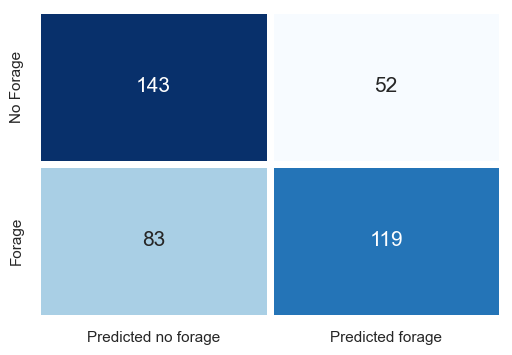

Precision Score: 0.695906432748538
Recall Score: 0.5891089108910891
Accuracy Score: 0.6599496221662469
F1 Score: 0.6380697050938338
Cross Val Score Insample 0.7217391304347827
Cross Val Score Outsample 0.6449367088607596


In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=100)
y_pred = lr.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
performance_lr = model_performance(lr,X_train, X_test, y_train, y_test)

## Random Forest

Number of mislabeled points out of a total 397 points : 115
RandomForestClassifier() Performance:



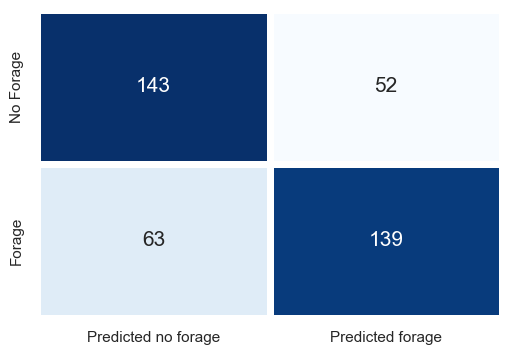

Precision Score: 0.7277486910994765
Recall Score: 0.6881188118811881
Accuracy Score: 0.7103274559193955
F1 Score: 0.7073791348600509
Cross Val Score Insample 0.7192546583850932
Cross Val Score Outsample 0.7104113924050633


In [11]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
y_pred = rfc.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
performance_rfc = model_performance(rfc,X_train, X_test, y_train, y_test)

## SVM

Number of mislabeled points out of a total 397 points : 138
SVC(kernel='linear') Performance:



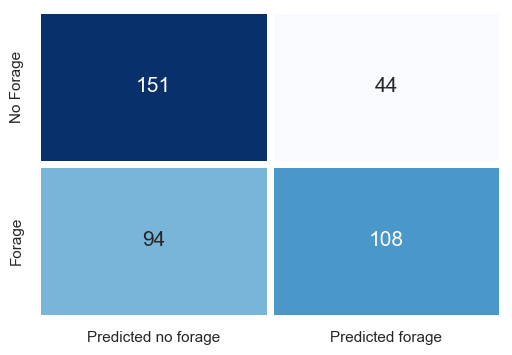

Precision Score: 0.7105263157894737
Recall Score: 0.5346534653465347
Accuracy Score: 0.6523929471032746
F1 Score: 0.6101694915254238
Cross Val Score Insample 0.724223602484472
Cross Val Score Outsample 0.6399367088607596


In [12]:
from sklearn.svm import SVC

svm = SVC(kernel = 'linear')
y_pred = svm.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
performance_svm = model_performance(svm,X_train, X_test, y_train, y_test)

- hour minute second combo / day and month combo
- include rest of days
- analysis for factors individually + weights